# Desigualdade de Gêneros em Hollywood

### Alunas:

Isadora Alves de Salles - _2017014553_ <br>
Laura Abreu Schulz Vieira- _2017015061_ <br>
Luiza Chagas Brandão Campos - _2017015010_


# Introdução:

Sabemos que desigualdade de gênero é uma pauta presente em várias áreas, assim com este trabalho buscamos evidenciar fatos já conhecidos sobre Hollywood correlacionados à gênero. A representatividade feminina em filmes é uma coisa que vem crescendo significantemente ao longo dos anos, mas antigamente era uma coisa que não existia. Uma das primeiras mulheres a fazerem parte do trio principal de um filme foi Carrie Fisher, interpretando a Princesa Leia. Portando, com esse trabalho nós tentaremos mostrar que a representatividade ainda é baixa, e que não segue a distribuição populacional, ou seja, vamos mostrar que o crescimento na representatividade ainda não chegou a igualdade. Assim como, provaremos que filmes dirigidos por mulheres tem uma representatividade feminina melhor do que filmes dirigidos por homens.

Além disso, em alguns filmes observamos que o par romântico é formado por um homem bem mais velho que a mulher, o que faz com que haja um amadurecimento maior sobre as mulheres. Possuindo dados sobre a idade do ator de um filme, tentaremos prever a idade do par romântico dele.


### Os dados que usaremos nesse trabalho se consistem em:
 - IMDb: dele extraimos as informações sobre ano do filme, cast principal, diretores, avaliação e gênero do filme.
 - TMDb: para conseguir o gênero dos atores e diretores precisamos buscar na API do TMDb, as tabelas de lá extraídas possuem um ID para as tabelas do IMDb. O merge das tabelas foi feito no outro arquivo .ipynb enviado no zip.
 - Hollywood Age Gap: com essa tabela teremos a informação sobre o gap entre a idade do homem e da mulher de um par romântico.
 
### Como esses dados se correlacionam:

Nós pretendemos evidenciar problemas correlacionados ao gênero existentes em Hollywood. Como não foi possível extrair todos os dados do TMDb, nós pegamos as informações apenas sobre os atores mais famosos, assim temos informações sobre os filmes que contam com pelo menos dois desses atores. Dessa forma, estamos trabalhando com dados que refletem a realidade sobre filmes mais famosos.

### Perguntas:

1. A representação feminina no cast principal dos filmes de Hollywood segue a distribuição populacional norte-americana?

2. O gênero do diretor do filme tem influência na quantidade de homens e mulheres no cast principal?

3. Podemos predizer qual a idade da mulher com base na idade de seu par romântico?


# Metodologia: 
 
 
 Para responder às nossas perguntas de pesquisa nós fizemos uso de dois testes de hipóteses, uma classificação e uma regressão. O passo a passo para cada um desses itens será explicado a seguir:

## Imports necessários

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
import random

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore")


# Resumo dos Dados e Análise Exploratória 


Antes de podermos dizer algo sobre os dados precisamos visualizá-los. <br>
Na tabela a seguir temos as informações que recolhermos sobre o TMDb

## TMDb

In [0]:
tmdb_infos = pd.read_csv('tmdb_infos.csv', sep=';', encoding='utf-8')


O gênero igual a 0 representa "não sei", sendo assim, foram excluídos da nossa análise.

In [0]:
tmdb_infos = tmdb_infos[tmdb_infos['gender'] != 0]
tmdb_infos.reset_index(inplace=True, drop=True)
tmdb_infos.head()

,birthday,known_for_department,deathday,id,name,gender,imdb_id
0,NaN,Acting,NaN,716.0,Jeannette Sousa,1,nm0815970
1,1964-09-02,Acting,NaN,38.0,Keanu Reeves,2,nm0000206
2,NaN,Acting,NaN,52234.0,Jocelyn Hudon,1,nm6749397
3,1989-10-01,Acting,NaN,7.0,Brie Larson,1,nm0488953
4,1979-07-24,Acting,NaN,82.0,Rose Byrne,1,nm0126284


In [0]:
print("Numero de linhas: {}".format(tmdb_infos.shape[0]))
print("Numero de colunas: {}".format(tmdb_infos.shape[1]))
print("Dados faltando: {}".format(tmdb_infos.isnull().sum().sum()))

Numero de linhas: 83119
Numero de colunas: 7
Dados faltando: 123612


Resumo sobre os dados faltantes na tabela do TMDb.

In [0]:
tmdb_infos.isnull().sum().to_frame("Dados faltando").join(   
    (tmdb_infos.isnull().sum().to_frame("%")*100/len(tmdb_infos)).round(2))

,Dados faltando,%
birthday,37860,45.55
known_for_department,10,0.01
deathday,72460,87.18
id,54,0.06
name,0,0.00
gender,0,0.00
imdb_id,13228,15.91


Excluímos as colunas que possuem muitos dados faltantes e a coluna id que representa o id do TMDb e não serão necessárias.

In [0]:
to_drop = ["birthday", "deathday", "id"]

tmdb_infos = tmdb_infos.drop(to_drop, axis=1)

Excluímos o restante das linhas que possuem dados faltantes.

In [0]:
n_before = tmdb_infos.shape[0]
tmdb_infos = tmdb_infos.dropna(axis=0, how="any")
print("\nLinhas removidas: {}".format(n_before - tmdb_infos.shape[0]))

# Certifica que nao ha mais dados faltando
assert tmdb_infos.isnull().sum().sum() == 0


Linhas removidas: 13234


In [0]:
female_sum = tmdb_infos[tmdb_infos['gender'] == 1]['gender'].count()
male_sum = tmdb_infos[tmdb_infos['gender'] == 2]['gender'].count()
print('Quantidade de mulheres na tabela: {}'.format(female_sum))
print('Quantidade de homens na tabela: {}'.format(male_sum))

Quantidade de mulheres na tabela: 27720
Quantidade de homens na tabela: 42165


### Quantidade de pessoas por gênero para cada área

In [0]:
tmdb_group = tmdb_infos[['known_for_department', 'gender', 'imdb_id']].groupby(['known_for_department', 'gender']).count()
tmdb_group

imdb_id
known_for_department gender         
Acting               1         22729
                     2         27380
Actors               2             1
Art                  1           409
                     2           715
Camera               1           129
                     2          1223
Costume & Make-Up    1           564
                     2           198
Creator              1            35
                     2            91
Crew                 1           273
                     2           998
Directing            1           887
                     2          3761
Editing              1           183
                     2           569
Lighting             1            10
                     2           289
Production           1          1337
                     2          1944
Sound                1           205
                     2          1350
Visual Effects       1            73
                     2           410
Writing              1           886
                     2          3236

## IMDb

A tabela a seguir possui as informações do IMDb mesclada com informações do TMDb sobre o gênero dos atores e diretores. A construção desse dataset foi feita no outro notebook que foi enviado no zip.

Com essas informações temos a pretensão de classificar o gênero do diretor, possuindo o restante das colunas como atributo. Antes da classificação iremos mostrar porque essa análise é válida com um teste de hipóteses.

In [0]:
df_merged = pd.read_csv('merged_final.csv', sep=';', encoding='utf-8')
df_merged.head()

,tconst,startYear,gender_actor1,gender_actor2,gender_actor3,gender_actor4,gender_director1,gender_director2,averageRating,numVotes,genres_film
0,tt0000644,1908,2,2,1.0,1.0,2,NaN,5.4,16.0,"Drama,Short"
1,tt0000645,1908,2,1,1.0,NaN,2,NaN,5.4,80.0,"Crime,Short"
2,tt0000663,1908,2,2,1.0,NaN,2,NaN,5.6,12.0,"Comedy,Short"
3,tt0000665,1908,2,2,1.0,NaN,2,NaN,5.8,12.0,"Drama,Short"
4,tt0000672,1908,2,1,NaN,NaN,2,NaN,6.3,10.0,"Drama,Short"


In [0]:
print("Numero de linhas: {}".format(df_merged.shape[0]))
print("Numero de colunas: {}".format(df_merged.shape[1]))
print("Dados faltando: {}".format(df_merged.isnull().sum().sum()))

Numero de linhas: 25814
Numero de colunas: 11
Dados faltando: 55487


Primeiro temos que tratar os dados faltantes da tabela. Como poucos filmes tem dois diretores podemos excluir a coluna "gender_director2" da nossa análise. Não excluíremos a coluna "gender_actor4" pois ela ainda será útil em análises futuras.

In [0]:
df_merged.isnull().sum().to_frame("Dados faltando").join(   
    (df_merged.isnull().sum().to_frame("%")*100/len(df_merged)).round(2))

,Dados faltando,%
tconst,0,0.00
startYear,0,0.00
gender_actor1,0,0.00
gender_actor2,0,0.00
gender_actor3,7700,29.83
gender_actor4,16741,64.85
gender_director1,0,0.00
gender_director2,25252,97.82
averageRating,2897,11.22
numVotes,2897,11.22


Excluímos também as colunas "tconst" e "startYear" que não serão usadas na nossa análise. Não precisamos remover as linhas restantes que possuem atributo nulo agora, pois os nulos restantes representam filmes que não possuem o ator 3 e 4 e/ou não foram avaliados no IMDb.

In [0]:
to_drop = ["gender_director2", "tconst","startYear"]

df_merged = df_merged.drop(to_drop, axis=1)

Abaixo temos dataset apenas com os filmes que foram avaliados e sua respectiva avaliação:

In [0]:
t_ratings = pd.read_csv('new_t_ratings.csv', sep=';', encoding='utf-8') 


In [0]:
print("Numero de linhas: {}".format(t_ratings.shape[0]))
print("Numero de colunas: {}".format(t_ratings.shape[1]))
print("Dados faltando: {}".format(t_ratings.isnull().sum().sum()))

Numero de linhas: 22917
Numero de colunas: 3
Dados faltando: 0


In [0]:
meanNumVotes = t_ratings['numVotes'].mean()
print("Média dos números de votos para todos os filmes: {}".format(meanNumVotes))

Média dos números de votos para todos os filmes: 20003.013003447224


Para uma melhor avaliação da média de avaliações dos filmes vamos fazer um bootstrap dos dados e mostrar o intervalo de confiança dos dados.

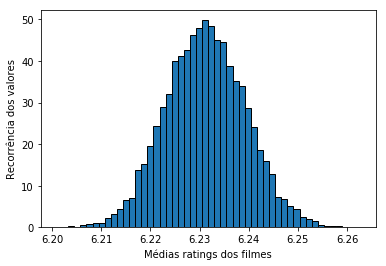

In [0]:
medias = []
for _ in range(10000):
  sample = t_ratings['averageRating'].sample(n=10000)
  medias.append(sample.mean())

plt.hist(medias, density=True, bins = 50, edgecolor='k')
plt.xlabel('Médias ratings dos filmes')
plt.ylabel('Recorrência dos valores')
plt.show()

In [0]:
print("[{}, {}]".format(np.percentile(medias, 2.5), np.percentile(medias, 97.5)))

[6.215009249999974, 6.246820249999986]



Portanto, as médias de rating dos filmes estão em um intervalo de confiança (95%) entre 6.22 e 6.25 (aproximadamente).
Agora, mostraremos a distribuição dos ratings dos filmes nos dados reais que possuimos.

### Distribuição das avaliações

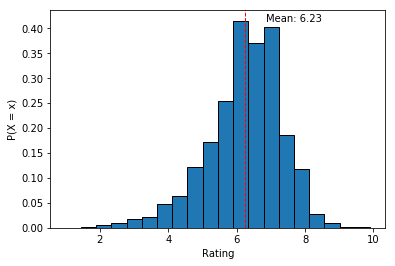

In [0]:
plt.hist(t_ratings['averageRating'], bins=20, density=True, edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('P(X = x)')
plt.axvline(t_ratings['averageRating'].mean(), color='r', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(t_ratings['averageRating'].mean() + t_ratings['averageRating'].mean()/10, 
         max_ - max_/20, 
         'Mean: {:.2f}'.format(t_ratings['averageRating'].mean()))
plt.show()

## Age Gap
Temos também informações sobre pares amorosos de alguns filmes e a idade de cada um no par. A partir dessas informações buscamos fazer uma regressão para tentar prever a idade da mulher dado a idade do homem. 

In [0]:
age_gap = pd.read_csv('hollywood_age_gap.csv', sep=',', encoding='utf-8')

Excluimos os casais homoafetivos, pois a nossa pretensão é expor a diferença de idade entre homens e mulheres como pares amorosos nos filmes, assim provando que, na concepção hollywoodiana, é muito mais aceitável a presença de um homem mais velho do que de uma mulher mais velha nas telas. 

In [0]:
for i in range (len(age_gap)):
  if age_gap['Actor 1 Gender'].loc[i] == age_gap['Actor 2 Gender'].loc[i]:
    age_gap = age_gap.drop([i])

age_gap.reset_index(drop=True)

print("Numero de linhas: {}".format(age_gap.shape[0]))
print("Numero de colunas: {}".format(age_gap.shape[1]))
print("Dados faltando: {}".format(age_gap.isnull().sum().sum()))

Numero de linhas: 1022
Numero de colunas: 12
Dados faltando: 0


In [0]:
age_gap.head()

,Movie Name,Release Year,Director,Age Difference,Actor 1 Name,Actor 1 Gender,Actor 1 Birthdate,Actor 1 Age,Actor 2 Name,Actor 2 Gender,Actor 2 Birthdate,Actor 2 Age
0,Harold and Maude,1971,Hal Ashby,52,Bud Cort,man,1948-03-29,23,Ruth Gordon,woman,1896-10-30,75
1,Venus,2006,Michael Curtiz,50,Peter O'Toole,man,1932-08-02,74,Jodie Whittaker,woman,1982-06-03,24
2,The Quiet American,2002,Phillip Noyce,49,Michael Caine,man,1933-03-14,69,Do Thi Hai Yen,woman,1982-10-01,20
3,The Big Lebowski,1998,Joel Coen,45,David Huddleston,man,1930-09-17,68,Tara Reid,woman,1975-11-08,23
5,Poison Ivy,1992,Katt Shea,42,Tom Skerritt,man,1933-08-25,59,Drew Barrymore,woman,1975-02-22,17


In [0]:
media_idade_homem = np.mean(age_gap['Actor 1 Age'])
media_idade_mulher = np.mean(age_gap['Actor 2 Age'])
maior_idade_homem = np.max(age_gap['Actor 1 Age'])
maior_idade_mulher = np.max(age_gap['Actor 2 Age'])
print('Media da idade do homem: {0:.2f}'.format(media_idade_homem))
print('Media da idade do mulher: {0:.2f}'.format(media_idade_mulher))
print("\n")
print('Maior idade do homem: {}'.format(maior_idade_homem))
print('Maior idade do mulher: {}'.format(maior_idade_mulher))

Media da idade do homem: 39.17
Media da idade do mulher: 30.96


Maior idade do homem: 79
Maior idade do mulher: 75


### Distribuição da idade da mulher

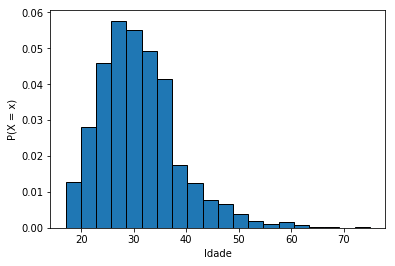

In [0]:
plt.hist(age_gap['Actor 2 Age'], bins=20, density=True, edgecolor='k')
plt.xlabel('Idade')
plt.ylabel('P(X = x)')
plt.show()

### Distribuição da idade do homem

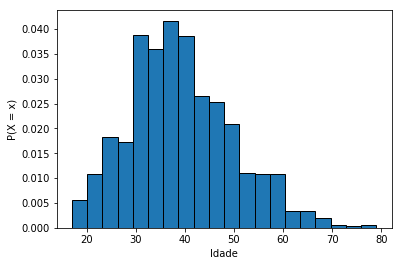

In [0]:
plt.hist(age_gap['Actor 1 Age'], bins=20, density=True, edgecolor='k')
plt.xlabel('Idade')
plt.ylabel('P(X = x)')
plt.show()

### Analisando a diferença de idade

In [0]:
media_diferenca = np.mean(age_gap['Age Difference'])
std_diferenca = np.std(age_gap['Age Difference'])

print("Média da diferença de idades: {}".format(media_diferenca))
print("Desvio da diferença de idades: {}".format(std_diferenca))

Média da diferença de idades: 9.930528375733855
Desvio da diferença de idades: 8.247401744364831


Text(10.92358121330724, 0.07770679662802951, 'Mean: 9.93')

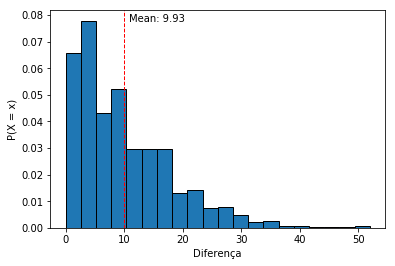

In [0]:
plt.hist(age_gap['Age Difference'], bins=20, density=True, edgecolor='k')
plt.xlabel('Diferença')
plt.ylabel('P(X = x)')
plt.axvline(age_gap['Age Difference'].mean(), color='r', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(age_gap['Age Difference'].mean() + age_gap['Age Difference'].mean()/10, 
         max_ - max_/20, 
         'Mean: {:.2f}'.format(age_gap['Age Difference'].mean()))

Com o histograma acima vemos que temos muitos dados com pouca diferença entre as idades, porém temos dados com uma diferença muito grande, e queremos focar neles e tentar explicá-los.
Para uma análise exploratória um pouco mais profunda desses dados, vamos fazer uma IC com as médias de diferenças de idade utilizando a técnica do Bootstrap, assim como feito acima.

Text(0, 0.5, 'Recorrência dos valores')

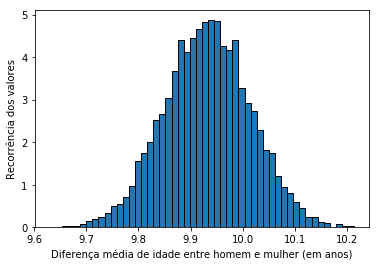

In [0]:
medias = []
for _ in range(10000):
  sample = age_gap['Age Difference'].sample(n=10000, replace=True)
  medias.append(sample.mean())

plt.hist(medias, density=True, bins = 50, edgecolor='k')
plt.xlabel('Diferença média de idade entre homem e mulher (em anos)')
plt.ylabel('Recorrência dos valores')

In [0]:
print("[{}, {}]".format(np.percentile(medias, 2.5), np.percentile(medias, 97.5)))

[9.770195, 10.093002499999999]


Portanto, as médias de diferença de idade entre os atores e atrizes principais dos filmes estão em um intervalo de confiança (95%) entre 9.77 e 10.09 anos (aproximadamente). 

###  Woody Allen

Decidimos analisar como essa diferença de idade é nos filmes do Woody Allen.
O diretor é conhecido por filmes com jovens garotas se relacionando com homens mais velhos. Essa diferença ganhou destaque em 1992 quando Allen, então com 57 anos, assumiu relação com a filha adotiva de sua ex-esposa de 22.  Allen também voltou a receber duras críticas em 2017, quando sua filha, Dylan Farrow, [voltou a afirmar ter sido abusada sexualmente pelo pai.](https://www.latimes.com/opinion/op-ed/la-oe-farrow-woody-allen-me-too-20171207-story.html)

In [0]:
df_woody = age_gap[age_gap['Director'] == 'Woody Allen']
df_woody.head()

,Movie Name,Release Year,Director,Age Difference,Actor 1 Name,Actor 1 Gender,Actor 1 Birthdate,Actor 1 Age,Actor 2 Name,Actor 2 Gender,Actor 2 Birthdate,Actor 2 Age
6,Whatever Works,2009,Woody Allen,40,Larry David,man,1947-07-02,62,Evan Rachel Wood,woman,1987-09-07,22
8,Husbands and Wives,1992,Woody Allen,38,Woody Allen,man,1935-12-01,57,Juliette Lewis,woman,1973-06-21,19
18,Hollywood Ending,2002,Woody Allen,33,Woody Allen,man,1935-12-01,67,Debra Messing,woman,1968-08-15,34
20,Mighty Aphrodite,1995,Woody Allen,32,Woody Allen,man,1935-12-01,60,Mira Sorvino,woman,1967-09-28,28
24,Mighty Aphrodite,1995,Woody Allen,31,Woody Allen,man,1935-12-01,60,Helena Bonham Carter,woman,1966-05-26,29


In [0]:
media_idade_homem = np.mean(df_woody['Actor 1 Age'])
media_idade_mulher = np.mean(df_woody['Actor 2 Age'])
media_diferenca = np.mean(df_woody['Age Difference'])
maior_idade_homem = np.max(df_woody['Actor 1 Age'])
maior_idade_mulher = np.max(df_woody['Actor 2 Age'])
print('Media da idade do homem: {0:.2f}'.format(media_idade_homem))
print('Media da idade do mulher: {0:.2f}'.format(media_idade_mulher))
print('Media da diferença: {}'.format(media_diferenca))

print()
print('Maior idade do homem: {}'.format(maior_idade_homem))
print('Maior idade do mulher: {}'.format(maior_idade_mulher))

Media da idade do homem: 49.40
Media da idade do mulher: 29.25
Media da diferença: 20.15

Maior idade do homem: 67
Maior idade do mulher: 47


# Testes de Hipóteses:

Primeiramente, vamos trabalhar com a seguinte hipótese nula: 
### A representação feminina no cast principal dos filmes de Hollywood segue a distribuição populacional norte-americana
Para verificar a hipótese, vamos analisar a proporção entre homens/mulheres com papéis protagonistas em filmes e verificar se essa proporção é fruto de uma possível amostra aleatória da população dos EUA.

In [0]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [0]:
female_sum_1 = df_merged[df_merged['gender_actor1'] == 1]['gender_actor1'].count()
female_sum_2 = df_merged[df_merged['gender_actor2'] == 1]['gender_actor2'].count()
female_sum_3 = df_merged[df_merged['gender_actor3'] == 1]['gender_actor3'].count()
female_sum_4 = df_merged[df_merged['gender_actor4'] == 1]['gender_actor4'].count()
total_female_sum = female_sum_1 + female_sum_2 + female_sum_3 + female_sum_4

print('Quantidade de atrizes: {}'.format(total_female_sum))

male_sum_1 = df_merged[df_merged['gender_actor1'] == 2]['gender_actor1'].count()
male_sum_2 = df_merged[df_merged['gender_actor2'] == 2]['gender_actor2'].count()
male_sum_3 = df_merged[df_merged['gender_actor3'] == 2]['gender_actor3'].count()
male_sum_4 = df_merged[df_merged['gender_actor4'] == 2]['gender_actor4'].count()
total_male_sum = male_sum_1 + male_sum_2 + male_sum_3 + male_sum_4

print('Quantidade de atores: {}'.format(total_male_sum))

prop_male_female = total_male_sum/total_female_sum
prop_male_female = round(prop_male_female, 2)

print('Proporção entre atores e atrizes como protagonistas: {}'.format(prop_male_female))


Quantidade de atrizes: 34162
Quantidade de atores: 44653
Proporção entre atores e atrizes como protagonistas: 1.31


Segundo a fonte https://www.indexmundi.com/pt/estados_unidos/populacao_perfil.html, a proporção total entre homens e mulheres nos EUA (2016) é de 0.97 (homens/mulheres), ou seja, a cada 100 mulheres existem 97 homens.

Queremos, então, verificar se a proporção de homens/mulheres como protagonistas em Hollywood segue a distribuição populacional dos EUA. Para isso, vamos gerar amostras aleatórias seguindo uma possível distribuição populacional e averiguar se a proporção encontrada em Hollywood está dentro do intervalo de confiança dessa distribuição.

Temos 78815 atores. Vamos gerar o número mais aproximado disso que siga a proporção entre homens/mulheres da distribuição populacional dos EUA. O número mais próximo que podemos utilizar para gerar a proporção é 78800, onde temos 40000 mulheres e 38800 homens (a proporção é exatamente 0.97 homens/mulheres).

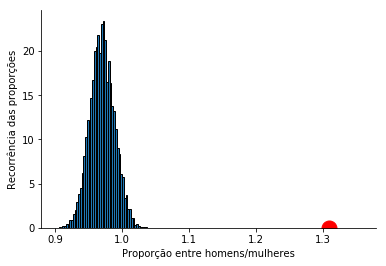

In [0]:
female = [1]*40000
male = [2]*38800
population = female + male 

proportions = []
for _ in range(10000):
  sample = random.sample(population,10000)
  n_fem = sample.count(1)
  proportions.append((10000-n_fem)/n_fem)

plt.hist(proportions, density=True, bins = 50, edgecolor='k')
despine()
plt.xlim(0.88, 1.38)
plt.xlabel('Proporção entre homens/mulheres')
plt.ylabel('Recorrência das proporções')
plt.plot([1.31], [0], 'ro', ms=15)



In [0]:
np.percentile(proportions, 97.5)

1.0064205457463884

Considerando o intervalo de confiança de 95%, percebemos que o número máximo aceitável de homens/mulheres é aproximadamente 1.01 (de acordo com as simulações que fizemos), o que é muito distante de 1.31 como é distribuido em Hollywood. Podemos, então, derrubar nossa hipótese nula e concluir que existe desigualdade de gênero na mais famosa indústria do cinema mundial, uma vez que a distribuição dos principais papéis ao longo dos anos não segue a distribuição populacional norte-americana.

Vamos trabalhar agora com outra hipótese nula:

### O gênero do diretor do filme não tem influência na quantidade de homens e mulheres no cast principal.
Para verificar a hipótese, vamos analisar qual é a proporção de homens/mulheres no cast principal apenas de filmes dirigidos por mulheres. A partir disso, vamos verificar se essa proporção é apenas um fruto da aleatoridade da distribuição total de proporção entre homens e mulheres independente do gênero do diretor.

**Análise para diretoras**

In [0]:
table_merged_female_dir = df_merged[df_merged['gender_director1'] == 1]
table_merged_female_dir.head()

,gender_actor1,gender_actor2,gender_actor3,gender_actor4,gender_director1,averageRating,numVotes,genres_film
230,2,1,1.0,NaN,1,5.6,147.0,Drama
257,2,1,1.0,1.0,1,5.5,14.0,"Comedy,Drama"
310,2,2,1.0,NaN,1,5.2,12.0,Drama
314,2,1,NaN,NaN,1,6.2,8.0,Drama
355,2,1,1.0,NaN,1,5.2,8.0,Drama


In [0]:
female_sum_1_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor1'] == 1]['gender_actor1'].count()
female_sum_2_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor2'] == 1]['gender_actor2'].count()
female_sum_3_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor3'] == 1]['gender_actor3'].count()
female_sum_4_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor4'] == 1]['gender_actor4'].count()
total_female_sum_fdir = female_sum_1_fdir + female_sum_2_fdir + female_sum_3_fdir + female_sum_4_fdir

print('Quantidade de atrizes: {}'.format(total_female_sum_fdir))

male_sum_1_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor1'] == 2]['gender_actor1'].count()
male_sum_2_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor2'] == 2]['gender_actor2'].count()
male_sum_3_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor3'] == 2]['gender_actor3'].count()
male_sum_4_fdir = table_merged_female_dir[table_merged_female_dir['gender_actor4'] == 2]['gender_actor4'].count()
total_male_sum_fdir = male_sum_1_fdir + male_sum_2_fdir + male_sum_3_fdir + male_sum_4_fdir

print('Quantidade de atores: {}'.format(total_male_sum_fdir))

prop_male_female_fdir = total_male_sum_fdir/total_female_sum_fdir
prop_male_female_fdir = round(prop_male_female_fdir, 2)

print('Proporção entre atores e atrizes como protagonistas: {}'.format(prop_male_female_fdir))

Quantidade de atrizes: 2474
Quantidade de atores: 2529
Proporção entre atores e atrizes como protagonistas: 1.02


> Agora que sabemos que a proporção entre homens/mulheres em filmes com diretoras mulheres é de 1.02 (e a total é 1.31). 

Vamos verificar se essa proporção está dentro do intervalo de confiança das proporções levando em conta todos os filmes, independentemente do gênero do diretor. Para isso: 
 - Vamos fazer um filtro da tabela que contém todas as informações que capta os filmes que tem apenas diretoras mulheres;
 - A partir disso, vamos fazer um teste de permutação, para que seja aleatório o cast em relação ao gênero do diretor;
 - Pegamos para cada permutação qual a proporção homem/mulher do cast apenas aonde foram alocadas as diretoras mulheres.

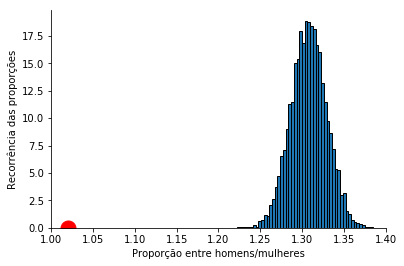

In [0]:
tab_teste_permut = df_merged.copy()
filtro = tab_teste_permut['gender_director1'] == 1

props_teste_permut = []
for _ in range(10000):
  np.random.shuffle(filtro.values)
  female_sum_1_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor1'] == 1]['gender_actor1'].count()
  female_sum_2_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor2'] == 1]['gender_actor2'].count()
  female_sum_3_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor3'] == 1]['gender_actor3'].count()
  female_sum_4_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor4'] == 1]['gender_actor4'].count()
  total_female_sum_fdir = female_sum_1_fdir + female_sum_2_fdir + female_sum_3_fdir + female_sum_4_fdir

  male_sum_1_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor1'] == 2]['gender_actor1'].count()
  male_sum_2_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor2'] == 2]['gender_actor2'].count()
  male_sum_3_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor3'] == 2]['gender_actor3'].count()
  male_sum_4_fdir = tab_teste_permut[filtro][tab_teste_permut['gender_actor4'] == 2]['gender_actor4'].count()
  total_male_sum_fdir = male_sum_1_fdir + male_sum_2_fdir + male_sum_3_fdir + male_sum_4_fdir

  prop_male_female_fdir = total_male_sum_fdir/total_female_sum_fdir

  props_teste_permut.append(prop_male_female_fdir)
  

plt.hist(props_teste_permut, density=True, bins = 50, edgecolor='k')
despine()
plt.xlim(1.0, 1.40)
plt.xlabel('Proporção entre homens/mulheres')
plt.ylabel('Recorrência das proporções')
plt.plot([1.02], [0], 'ro', ms=15)


In [0]:
np.percentile(props_teste_permut, 2.5)

1.26603204413998

Considerando o intervalo de confiança de 95%, percebemos que a proporção mínima de homens/mulheres que obtemos em uma distribuição aleatória na tabela entre o cast e o gênero dos diretores é de aproximadamente 1.27,  enquanto temos uma proporção 1.02 ao analisarmos os dados reais de diretoras mulheres.
Com isso, podemos derrubar nossa hipótese nula e concluir, então, que o gênero do diretor do filme influencia, sim, na representatividade de 
gênero do casting principal.

# Regressão:

Nós buscamos prever a idade da mulher no par romântico, dada a idade do homem utilizando uma regressão linear.

### Regressão utilizando todos os dados

Coefficient:  [[0.41013019]]
Intercept:  [-0.01344699]
Mean squared error: 0.77
Variance score: 0.31


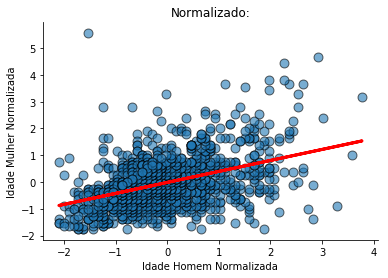

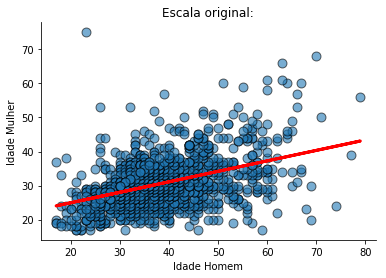

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



X = pd.DataFrame(age_gap['Actor 1 Age']) #X_h = homens_n['idade']
y = pd.DataFrame(age_gap['Actor 2 Age'])


X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)
#scaling (Normalização)

scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)
X = scaler_X.transform(X)
y = scaler_y.transform(y)
X_train = scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)


regr = LinearRegression()
regr.fit(X_train, y_train)


# The coefficients
print('Coefficient: ', regr.coef_)
print("Intercept: ", regr.intercept_)

y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs

y_pred = regr.predict(X)

plt.scatter(X, y, edgecolor='k', alpha=0.6, s=80)
plt.plot(X, y_pred, color='red', linewidth=3)
plt.title('Normalizado:')
plt.xlabel('Idade Homem Normalizada')
plt.ylabel('Idade Mulher Normalizada')
despine()
plt.show()


y_new_inverse = scaler_y.inverse_transform(y_pred)

plt.scatter(age_gap['Actor 1 Age'],age_gap['Actor 2 Age'], edgecolor='k', alpha=0.6, s=80)
plt.plot(age_gap['Actor 1 Age'], y_new_inverse, color='red', linewidth=3)
plt.title('Escala original:')
plt.xlabel('Idade Homem')
plt.ylabel('Idade Mulher')
despine()
plt.show()

Com a regressão acima não tivemos muitas informações. Pudemos perceber a a idade do homem tende a ser maior que a da mulher, mas o excesso de informações (muitas idades iguais) não permite uma boa regressão.
Por isso decidimos mudar nossa abordagem para diminuir a quantidade de dados;

### Diminuindo os dados usando médias

Para diminuir a quantidade de pontos e poder melhor compreender os dados criamos duas tabelas: 'Homens' que tem todas as idades de homens e 'Mulheres' que tem todas as idades de mulheres.

Para cada uma das idades nessas tabelas tiramos a média de idade do par romântico.

Exemplo:
- Na tabela homens: 
  - Homem com 19 anos -> mulher de 24.4 anos
  - Homem de 30 anos -> mulher de 27.9556 anos
- Na tabela mulheres:
  - Mulher de 19 anos -> homem de 30.4211 anos 
  - Mulher de 30 anos -> homem de  40.0179 anos

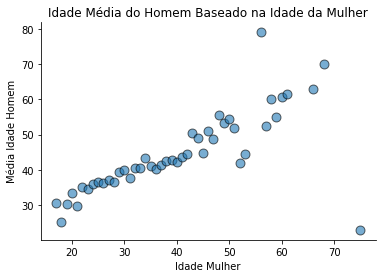

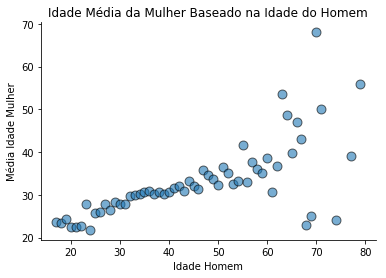

In [0]:
#Para os homens
idades_h = age_gap['Actor 1 Age'].drop_duplicates(keep='first')
idades_h.sort_values(axis=0, ascending=True, inplace=True, kind='quicksort')
idades_h.reset_index(inplace = True, drop = True)

homens = pd.DataFrame(columns=["idade", "Soma", "Count", "Media"])
homens['idade'] = idades_h


for i in range (len(homens.idade)):
  age = homens['idade'].loc[i]
  homens.at[i,'Count'] = age_gap[age_gap['Actor 1 Age']==age].Director.count()
  homens.at[i,'Soma'] = age_gap.loc[age_gap['Actor 1 Age'] == age, 'Actor 2 Age'].sum()
  homens.at[i,'Media'] = homens.at[i,'Soma']/homens.at[i,'Count']




#Para as mulheres
idades_m = age_gap['Actor 2 Age'].drop_duplicates(keep='first')
idades_m.sort_values(axis=0, ascending=True, inplace=True, kind='quicksort')
idades_m.reset_index(inplace = True, drop = True)

mulheres = pd.DataFrame(columns=["idade", "Soma", "Count", "Media"])
mulheres['idade'] = idades_m


for i in range (len(mulheres.idade)):
  age = mulheres['idade'].loc[i]
  mulheres.at[i,'Count'] = age_gap[age_gap['Actor 2 Age']==age].Director.count()
  mulheres.at[i,'Soma'] = age_gap.loc[age_gap['Actor 2 Age'] == age, 'Actor 1 Age'].sum()
  mulheres.at[i,'Media'] = mulheres.at[i,'Soma']/mulheres.at[i,'Count']

  
  
plt.scatter(mulheres['idade'], mulheres['Media'], edgecolor='k', alpha=0.6, s=80)
plt.title('Idade Média do Homem Baseado na Idade da Mulher')
plt.xlabel('Idade Mulher')
plt.ylabel('Média Idade Homem')
despine()
plt.show()

plt.scatter(homens['idade'], homens['Media'], edgecolor='k', alpha=0.6, s=80)
plt.title('Idade Média da Mulher Baseado na Idade do Homem')
plt.xlabel('Idade Homem')
plt.ylabel('Média Idade Mulher')
despine()
plt.show()

#age_gap_mean

#tirando Soma e Count

homens.drop(columns=["Soma", "Count"], inplace = True)
mulheres.drop(columns=["Soma", "Count"], inplace = True)

Regressão Homens:
Coefficients homem:  [[0.69930997]]
Intercept homem:  [0.01612429]
Mean squared error homem: 0.03
Variance score homem: 0.90


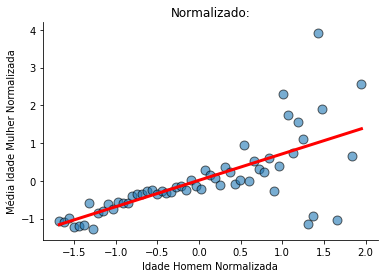

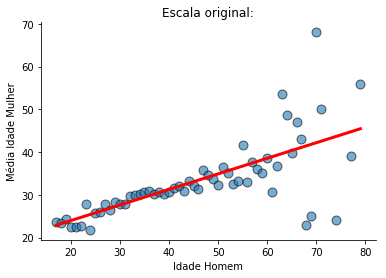

Regressão Mulheres:
Coefficients mulher:  [[0.68354193]]
Intercept mulher:  [-0.00367495]
Mean squared error mulher: 0.09
Variance score mulher: 0.81


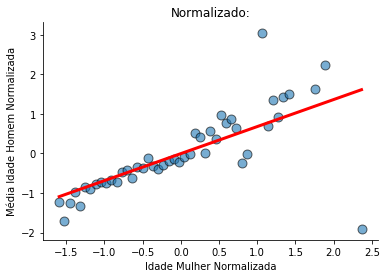

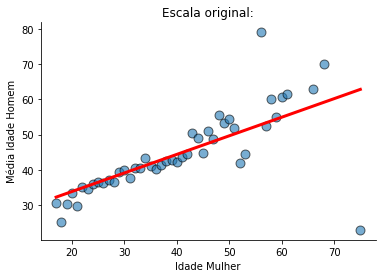

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



# Regressão Homens
print("Regressão Homens:")
X_h = pd.DataFrame(homens['idade']) #X_h = homens_n['idade']
y_h = pd.DataFrame(homens['Media'])



X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, random_state=0)
#scaling (Normalização)

scaler_X_h = StandardScaler().fit(X_h)
scaler_y_h = StandardScaler().fit(y_h)
X_h = scaler_X_h.transform(X_h)
y_h = scaler_y_h.transform(y_h)
X_train_h = scaler_X_h.transform(X_train_h)
y_train_h = scaler_y_h.transform(y_train_h)
X_test_h = scaler_X_h.transform(X_test_h)
y_test_h = scaler_y_h.transform(y_test_h)


regr_h = LinearRegression()
regr_h.fit(X_train_h, y_train_h)


# The coefficients
print('Coefficients homem: ', regr_h.coef_)
print("Intercept homem: ", regr_h.intercept_)

y_pred_h = regr_h.predict(X_test_h)

# The mean squared error
print("Mean squared error homem: %.2f"
      % mean_squared_error(y_test_h, y_pred_h))
# Explained variance score: 1 is perfect prediction
print('Variance score homem: %.2f' % r2_score(y_test_h, y_pred_h))

# Plot outputs

y_pred_h = regr_h.predict(X_h)

plt.scatter(X_h, y_h, edgecolor='k', alpha=0.6, s=80)
plt.plot(X_h, y_pred_h, color='red', linewidth=3)
plt.title('Normalizado:')
plt.xlabel('Idade Homem Normalizada')
plt.ylabel('Média Idade Mulher Normalizada')
despine()
plt.show()


y_new_inverse = scaler_y_h.inverse_transform(y_pred_h)

plt.scatter(homens['idade'],homens['Media'], edgecolor='k', alpha=0.6, s=80)
plt.plot(homens['idade'], y_new_inverse, color='red', linewidth=3)
plt.title('Escala original:')
plt.xlabel('Idade Homem')
plt.ylabel('Média Idade Mulher')
despine()
plt.show()

# Regressão Mulheres
print("Regressão Mulheres:")
X_m = pd.DataFrame(mulheres['idade']) #X_m = homens_n['idade']
y_m = pd.DataFrame(mulheres['Media'])



X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=0)

#scaling (Normalização)

scaler_X_m = StandardScaler().fit(X_m)
scaler_y_m = StandardScaler().fit(y_m)
X_m = scaler_X_m.transform(X_m)
y_m = scaler_y_m.transform(y_m)
X_train_m = scaler_X_m.transform(X_train_m)
y_train_m = scaler_y_m.transform(y_train_m)
X_test_m = scaler_X_m.transform(X_test_m)
y_test_m = scaler_y_m.transform(y_test_m)


regr_m = LinearRegression()
regr_m.fit(X_train_m, y_train_m)


# The coefficients
print('Coefficients mulher: ', regr_m.coef_)
print("Intercept mulher: ", regr_m.intercept_)

y_pred_m = regr_m.predict(X_test_m)

# The mean squared error
print("Mean squared error mulher: %.2f"
      % mean_squared_error(y_test_m, y_pred_m))
# Explained variance score: 1 is perfect prediction
print('Variance score mulher: %.2f' % r2_score(y_test_m, y_pred_m))

# Plot outputs

y_pred_m = regr_m.predict(X_m)

plt.scatter(X_m, y_m, edgecolor='k', alpha=0.6, s=80)
plt.plot(X_m, y_pred_m, color='red', linewidth=3)
plt.title('Normalizado:')
plt.xlabel('Idade Mulher Normalizada')
plt.ylabel('Média Idade Homem Normalizada')
despine()
plt.show()


y_new_inverse = scaler_y_m.inverse_transform(y_pred_m)

plt.scatter(mulheres['idade'],mulheres['Media'], edgecolor='k', alpha=0.6, s=80)
plt.plot(mulheres['idade'], y_new_inverse, color='red', linewidth=3)
plt.title('Escala original:')
plt.xlabel('Idade Mulher')
plt.ylabel('Média Idade Homem')
despine()
plt.show()



A utilização das médias das idades reduziu imensamente nossos dados, além disso passamos a ter correspondência direta entre x e y.

Por essa nova análise pudemos perceber que:
- A idade do homem tende a ser cerca de 10 anos superior a da mulher;
- A idade da mulher não costuma passar dos 45 anos, independentemente da idade dos homens

Nossas descobertas são reforçadas pelos histogramas (plotados anteriormente) e, até mesmo, pela antiga regressão que já havia indicado uma tendência a idades maiores nos homens

# Classificação

Queremos ver se é possível predizer o gênero do diretor a partir do gênero do cast principal, da avaliação do filme e do gênero do filme. Para isso iremos utilizar a tabela criada com as informações do IMDb e do TMDb.



In [0]:
# variáveis utilizadas
TARGET = "gender_director1"

K_Folds = 5

Agora precisamos excluir alguns dados faltantes que ainda existem na nossa tabela para poder fazer a classificação.

In [0]:
df_merged.isnull().sum().to_frame("Dados faltando").join(   
    (df_merged.isnull().sum().to_frame("%")*100/len(df_merged)).round(2))

,Dados faltando,%
gender_actor1,0,0.00
gender_actor2,0,0.00
gender_actor3,7700,29.83
gender_actor4,16741,64.85
gender_director1,0,0.00
averageRating,2897,11.22
numVotes,2897,11.22
genres_film,0,0.00


In [0]:
to_drop = ["gender_actor4"]

df_merged = df_merged.drop(to_drop, axis=1)

Precisamos remover as linhas restantes que ainda possuem algum atributo nulo.

In [0]:
n_before = df_merged.shape[0]
df_merged = df_merged.dropna(axis=0, how="any")
print("\nLinhas removidas: {}".format(n_before - df_merged.shape[0]))

# Certifica que nao ha mais dados faltando
assert df_merged.isnull().sum().sum() == 0


Linhas removidas: 9642


Cada filme pode ter até 3 gêneros, que são atributos categóricos, e nós devemos tranformá-los em números.

In [0]:
cleaned = df_merged.genres_film.str.split(',', expand=True)
cleaned

,0,1,2
0,Drama,Short,None
1,Crime,Short,None
2,Comedy,Short,None
3,Drama,Short,None
6,Action,Short,Western
14,Drama,Short,None
16,Comedy,Short,None
18,Comedy,Drama,Short
21,Drama,Short,None
24,Comedy,Short,None


Temos muitos dados faltando para gêneros 2 e 3, para não excluir mais linhas da nossa tabela vamos utilizar só o gênero 1 como atributo para nossa classificação.

In [0]:
cleaned.isnull().sum().to_frame("Dados faltando").join(
    (cleaned.isnull().sum().to_frame("%")*100/len(cleaned)).round(2))

,Dados faltando,%
0,0,0.00
1,4652,28.77
2,9630,59.55


Precisamos codificar nossos atributos categóricos, que no caso é o gênero do filme, para numérico. Escolhemos fazer uso de substituição da palavra por um número, ao invés de one-hot encoding.

In [0]:
def number_encode_features(array):
    result = array
    r = array
    encoders = {}
    encoders = preprocessing.LabelEncoder()
    r = encoders.fit_transform(result.astype(str))
    return r, encoders

In [0]:
encoded_genre1, _ = number_encode_features(cleaned[0])

In [0]:
df_merged["genres_film"] = encoded_genre1

In [0]:
df_merged.head()

,gender_actor1,gender_actor2,gender_actor3,gender_director1,averageRating,numVotes,genres_film
0,2,2,1.0,2,5.4,16.0,7
1,2,1,1.0,2,5.4,80.0,5
2,2,2,1.0,2,5.6,12.0,4
3,2,2,1.0,2,5.8,12.0,7
6,2,2,1.0,2,5.1,15.0,0


Listamos as features excluindo a target, que é o gênero do diretor.

In [0]:
features = list(df_merged.columns)
features.remove(TARGET)

z-normalizamos o dado

In [0]:
df_merged[features] = df_merged[features] - df_merged[features].mean()
df_merged[features] = df_merged[features]/df_merged[features].std()

Separamos o dado em treino, validação e teste.

In [0]:
X = df_merged[features].values
y = df_merged[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

kf = KFold(n_splits = K_Folds, random_state = 1, shuffle = True)

A função abaixo será usada para plotar a curva de acurácia no treino e na validação.

In [0]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label= "Training")
    plt.plot(x, y2, label= "Validation")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

Escolhemos utilizar o random forest pelo fato de estarmos trabalhando com dados que são muito facilmente separáveis por uma decision tree, pois alguns dos atributos possuem apenas resposta 1 ou 2, para representar os gêneros. Além disso, buscamos um método que não os levaria a decorar os dados, por exemplo, decorar que um determinado tipo de gênero de filme é dirigido somente por homens na nossa tabela. Para que isso não ocorresse seria importante a escolha de um modelo que utilizasse uma abordagem de bagging ou boosting. Portanto, escolhemos o Random Forest pois este modelo ataca a variância dos dados utilizando várias decision trees, em que nenhuma delas nunca verá o dado por completo e nem mesmo todas as features, assim produzimos árvores que não se correlacionam e não é possível que o modelo decore os dados, ou seja, não ocorre overfitting.


Pelo fato de termos classes desbalanceadas, ou seja, temos muito mais homens diretores do que mulheres, utilizamos o parâmetro *class_weight="balanced"*.

In [0]:
def random_forest(N):
    train_score = []
    val_score = []
    
    for train, val in kf.split(X, y):
           
        classifier = ensemble.RandomForestClassifier(n_estimators=N, class_weight="balanced")
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))


    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    
    return trainAcc, valAcc

Como podemos ver abaixo a acurácia de teste sempre cresce, mas a de validação não cai, ou seja, não ocorre overfitting. 

O gráfico foi plotado com a intenção de encontrar o melhor número de estimadores para fazer a predição. Nesse caso, o melhor número é 17.

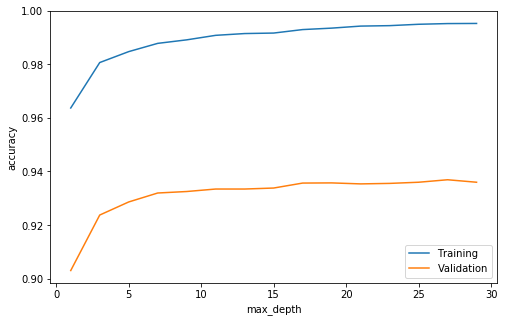

In [0]:
acc_modelTrain = []
acc_modelVal = []
max_depth = list(range(1,31,2)) #Valores usados para variar a quantidade de arvores 
for i in max_depth:
    trainAcc, valAcc = random_forest(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(max_depth, acc_modelTrain, acc_modelVal, "max_depth", "accuracy")

Como há um certo desbalanceamento de classes, devido a falta de representatividade feminina na direção de filmes, a previsão não ficou boa para a classe 1 (que representa as mulheres), abaixo podemos observar que todas as métricas ficaram bem baixas. Em contra partida, a previsão foi ótima para a classe 2, devido a alta quantidade de exemplos dessa classe no nosso dataset, foi muito mais fácil generalizar o dado e prever quais atributos importam quando o diretor é um homem.

In [0]:
model = ensemble.RandomForestClassifier(n_estimators=17, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
print("Test accuracy: {}\n".format(acc_test))

print(classification_report(y_test, y_pred))

Test accuracy: 0.9413528199362938

              precision    recall  f1-score   support

           1       0.19      0.04      0.07       274
           2       0.95      0.99      0.97      5063

    accuracy                           0.94      5337
   macro avg       0.57      0.52      0.52      5337
weighted avg       0.91      0.94      0.92      5337



In [0]:
# Matriz de Confusao
classes = ["1", "2"]
def matriz_confusao(y_test, y_pred):
  cm = metrics.confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Matriz de Confusão",
         ylabel="Real",
         xlabel="Predito")

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], "d"),
                  ha="center", va="center",
                  color="white" if cm[i, j] > cm.max()/2. else "black")
  fig.tight_layout()
  plt.show()

Na matriz de confusão abaixo temos uma representação visual das métricas mostradas acima. Podemos ver que a predição de verdadeiros positivos foi muito baixa, enquanto que a de verdadeiros negativos foi altíssima. Novamentes, isso pode ser explicado pelo desbalanceamento no dataset, visto que temos poucas diretoras. 

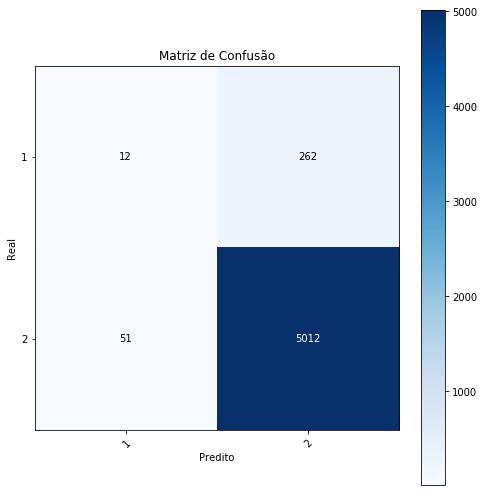

In [0]:
matriz_confusao(y_test, y_pred)

A classificação teve uma acurácia alta devido principalmente aos acertos de verdadeiros negativos. Podemos dizer que sim é possível prever o gênero do diretor dado os atributos que tínhamos em mãos, e que a representatividade do cast principal pode sim ser influênciada pelo gênero do diretor, isso também foi provado pelo teste de hipóteses. Porém, devido a falta de representatividade dentro da direção, não possuímos dados balanceados para essa análise, e podemos dizer que há um certo tipo de viés no dado, que é um viés natural que representa a desigualdade de gênero nessa área. Como há poucas diretoras, não foi possível generalizar tão bem o dado e encontrar padrões o suficiente para prever a classe 1 tão bem quanto prevemos a classe 2.

# Conclusão
 
No inicio do trabalho logo após a análise exploratória dos dados, na qual podemos ver como as tabelas se correlacionam, nós comprovamos que há desigualdade de gênero no cast principal dos filmes, utilizando a hipótese nula "a representação feminina no cast principal dos filmes de Hollywood segue a distribuição populacional norte-americana" e falsificando-a. 

Depois disso buscamos evidenciar como se comporta a representatividade no filme com a mudança do gênero do diretor, e mostramos que filmes que foram digiridos por mulheres tem uma representação feminina maior no cast principal, assim concluímos que o gênero do diretor influência na representatividade do filme. Dado isso, queríamos analisar o contrário e ver se a representatividade dos filmes influência no gênero do diretor. Então decidimos tentar classificar o gênero do diretor de um filme dado o restante de atributos que tínhamos, com isso conseguimos perceber que é possível fazer a classificação, porém os dados que temos não foram suficientes pois estão desbalanceados. Esse desbalanceamento é na verdade só mais um indicativo da baixa representatividade feminina, já que temos as informações dos filmes mais famosos e uma proporção de homens muito superior a mulheres na direção. Devido a isso, conseguimos prever bem quando o diretor é homem, porém para mulheres os resultados não foram tão bons quanto o esperado.

Além disso, nós também tentamos evidenciar que para Hollywood é muito mais aceitável termos homens mais velhos nas telas do que mulheres mais velhas, sendo assim os casais são formados na maioria das vezes por um homem mais velho e uma mulher nova. Para mostrar isso usamos uma regressão linear e conseguimos predizer a idade da mulher dada a idade do seu par romântico, e além disso conseguimos ver que as atrizes são em média 10 anos mais novas que seus pares românticos.
 
 